In [5]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.externals import joblib
from sklearn.preprocessing import QuantileTransformer
from sklearn import model_selection
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import linear_model
from sklearn import ensemble

Function for plotting learning curves

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, scoring="r2", train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Function for plotting validation curves

In [3]:
def plot_validation_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, param_name="alpha", scoring="r2", param_range = np.linspace(0.0, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Parameter range")
    plt.ylabel(scoring)
    train_scores, test_scores = model_selection.validation_curve(
        estimator, X, y, cv=cv, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
    plt.legend(loc="best")
    return plt

In [2]:
data = joblib.load('final_etsy_data.pkl')

Only look at products with a price < $250

In [4]:
reduced_data = data[data['price'] < 250]
views = np.array(reduced_data['views_week'].tolist())
joblib.dump(views, "views_250.pkl")

['views_250.pkl']

In [7]:
reduced_data = data[data['price'] < 250]
prices = np.array(reduced_data['price'].tolist())
views = np.array(reduced_data['views_week'].tolist())
features = np.array(reduced_data[0].tolist())

Save reduced data to disk

In [ ]:
joblib.dump(prices, "prices_250.pkl")
joblib.dump(features, "features_250.pkl")

Transform features with TF-IDF

In [8]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(features)

Save transformed reduced features to disk

In [ ]:
joblib.dump(X, "tfidf_vectorized_features_250.pkl")

Load prices and TF-IDF vectorized features

In [3]:
prices = joblib.load('prices_250.pkl')
features = joblib.load('tfidf_vectorized_features_250.pkl')

'00:11:04'

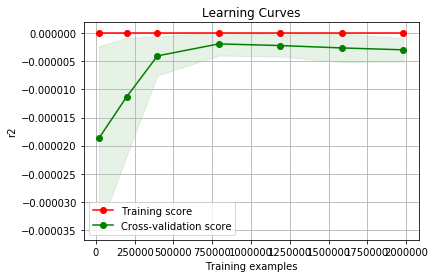

In [5]:
title = "Learning Curves"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

start_time = time.time()
estimator = linear_model.Lasso()
plot_learning_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, scoring="r2", train_sizes=[.01, .1, .2, .4, .6, .8, 1.0])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

0.4 appears to be the best train size, now vary alpha (L1 term)

'02:05:09'

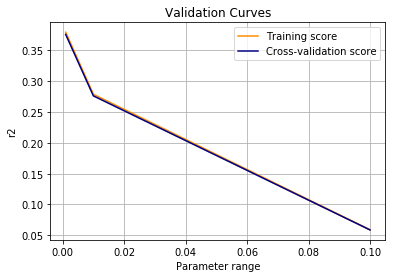

In [7]:
title = "Validation Curves"
cv = model_selection.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
start_time = time.time()
estimator = linear_model.Lasso()
plot_validation_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, param_name="alpha", scoring="r2", param_range=[.001, .01, .1])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:21:14'

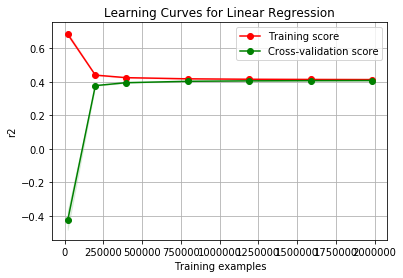

In [10]:
title = "Learning Curves for Linear Regression"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

start_time = time.time()
estimator = linear_model.LinearRegression()
plot_learning_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, scoring="r2", train_sizes=[.01, .1, .2, .4, .6, .8, 1.0])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

Gradient Boosting Exploration

'00:38:05'

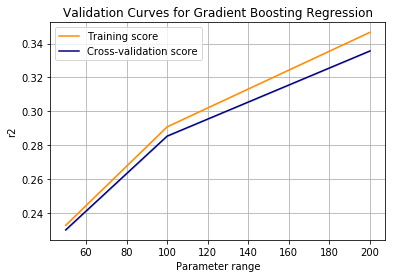

In [19]:
title = "Validation Curves for Gradient Boosting Regression"
cv = model_selection.ShuffleSplit(n_splits=1, train_size = 0.25, test_size=0.05, random_state=0)
start_time = time.time()
estimator = ensemble.GradientBoostingRegressor(max_depth=4, random_state=0, verbose=1)
plot_validation_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, param_name="n_estimators", scoring="r2", param_range=[50, 100, 200])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:37:08'

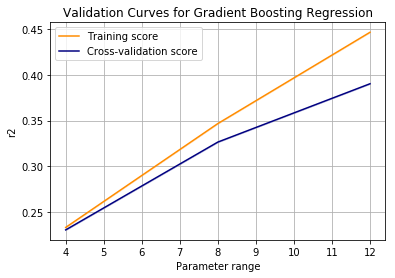

In [20]:
title = "Validation Curves for Gradient Boosting Regression"
cv = model_selection.ShuffleSplit(n_splits=1, train_size = 0.25, test_size=0.05, random_state=0)
start_time = time.time()
estimator = ensemble.GradientBoostingRegressor(n_estimators=50, random_state=0, verbose=1)
plot_validation_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, param_name="max_depth", scoring="r2", param_range=[4, 8, 12])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:37:45'

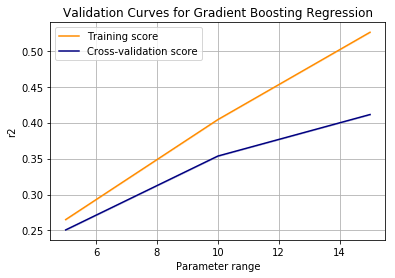

In [22]:
title = "Validation Curves for Gradient Boosting Regression"
cv = model_selection.ShuffleSplit(n_splits=1, train_size = 0.2, test_size=0.02, random_state=0)
start_time = time.time()
estimator = ensemble.GradientBoostingRegressor(n_estimators=50, random_state=0, verbose=1)
plt1 = plot_validation_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, param_name="max_depth", scoring="r2", param_range=[5, 10, 15])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:06:28'

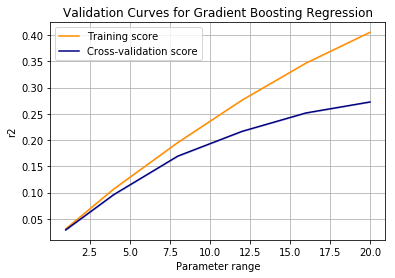

In [27]:
title = "Validation Curves for Gradient Boosting Regression"
cv = model_selection.ShuffleSplit(n_splits=1, train_size = 0.1, test_size=0.01, random_state=0)
start_time = time.time()
estimator = ensemble.GradientBoostingRegressor(n_estimators=10, random_state=0, verbose=1)
plt2 = plot_validation_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, param_name="max_depth", scoring="r2", param_range=[1, 4, 8, 12, 16, 20])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'00:37:52'

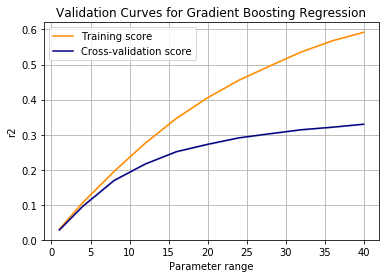

In [30]:
title = "Validation Curves for Gradient Boosting Regression"
cv = model_selection.ShuffleSplit(n_splits=1, train_size = 0.1, test_size=0.01, random_state=0)
start_time = time.time()
estimator = ensemble.GradientBoostingRegressor(n_estimators=10, random_state=0, verbose=1)
plot_validation_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, param_name="max_depth", scoring="r2", param_range=[1, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

'02:22:29'

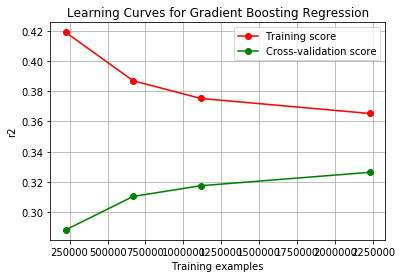

In [31]:
title = "Learning Curves for Gradient Boosting Regression"
cv = model_selection.ShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

start_time = time.time()
estimator = ensemble.GradientBoostingRegressor(n_estimators=10, max_depth=20, random_state=0, verbose=1)
plot_learning_curve(estimator, title, features, prices, cv=cv, n_jobs=-1, scoring="r2", train_sizes=[.1, .3, .5, 1.0])
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

Perform Gradient Boosting Regression

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, prices, test_size = 0.2, random_state = 0, shuffle=True)

In [40]:
estimator = ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=15, subsample=0.4, random_state=0, verbose=1)

In [41]:
estimator.fit(X_train, y_train)
joblib.dump(estimator, "price_estimator_no_transform.pkl")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1254.4430          68.2324          429.33m
         2        1178.4676          56.1875          443.26m
         3        1134.0148          48.5647          446.35m
         4        1096.1506          41.6448          438.00m
         5        1065.6042          32.7527          428.03m
         6        1028.2372          30.1512          426.38m
         7         998.7866          24.4394          416.50m
         8         974.9850          21.3585          410.09m
         9         959.6272          16.7763          401.43m
        10         939.5568          15.9520          396.92m
        20         836.9962           6.5828          348.19m
        30         776.6545           3.1294          304.30m
        40         746.0247           2.3456          261.12m
        50         722.7877           1.8875          229.49m
        60         702.6136           1.0547          200.79m
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=0.25, tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)